# I - Importation des données

### Création de la base de données base.db

In [82]:
import sqlite3

connexion = sqlite3.connect('base.db')
curseur = connexion.cursor()

# Création de la table Températures
curseur.execute(""" CREATE TABLE IF NOT EXISTS Temperatures (
                    date TEXT PRIMARY KEY UNIQUE, 
                    temperature_moyenne INTEGER
                )
                """)

# Création de la table Gares
curseur.execute(""" CREATE TABLE IF NOT EXISTS Gares (
                    nom_gare TEXT PRIMARY KEY,
                    latitude REAL,
                    longitude REAL,
                    frequentation_2019 INTEGER,
                    frequentation_2020 INTEGER,
                    frequentation_2021 INTEGER
                )
                """)

# Création de la table objets trouvés
curseur.execute(""" CREATE TABLE IF NOT EXISTS Objets_trouves (
                    id INTEGER PRIMARY KEY AUTOINCREMENT UNIQUE,
                    date TEXT,
                    type TEXT,
                    nom_gare TEXT,
                    code_uic INTEGER,
                    FOREIGN KEY (nom_gare) REFERENCES Gares(nom_gare),
                    FOREIGN KEY (date) REFERENCES Temperatures(date)
                    )""")


connexion.commit()
connexion.close()

#### Objets trouvés

In [83]:
import requests
import pandas as pd
import sqlite3
import urllib.parse


url1 = "https://ressources.data.sncf.com/api/records/1.0/search/?dataset=objets-trouves-restitution&q=gc_obo_gare_origine_r_name+%3D+%22"
url2 = "&sort=date&facet=date&facet=gc_obo_date_heure_restitution_c&facet=gc_obo_gare_origine_r_name&facet=gc_obo_nature_c&facet=gc_obo_type_c&facet=gc_obo_nom_recordtype_sc_c&timezone=Europe%2FParis&rows=-1"


gares = ['Paris Gare de Lyon', 'Paris Montparnasse', 'Paris Gare du Nord', 'Paris Saint-Lazare', 'Paris Est', 'Paris Bercy', 'Paris Austerlitz']
date =[2019, 2020,2021,2022]

data_frames = []
for g in gares:
    for d in date:
        api_url = f"{url1}{urllib.parse.quote(g)}%22+AND+date%3D{str(d)}{url2}"
        response = requests.get(api_url)
        data = response.json()
        records = data["records"]
        record_fields = [record["fields"] for record in records]
        data_frames.append(record_fields)



### Import des données sur les objets trouvés

In [84]:
connexion = sqlite3.connect("base.db")
curseur = connexion.cursor()
for n in range(len(data_frames)):
    for item in data_frames[n]:
    # Extract the variables and values
       date = item['date']
       type = item['gc_obo_type_c']
       gare = item['gc_obo_gare_origine_r_name']
       code_uic = item['gc_obo_gare_origine_r_code_uic_c']
       curseur.execute("INSERT INTO Objets_trouves (date,type,nom_gare,code_uic) VALUES (?,?, ?, ?)", (date, type,gare, code_uic))
connexion.commit()
connexion.close()


In [85]:
connexion = sqlite3.connect("base.db")
curseur = connexion.cursor()
curseur.execute("""UPDATE Objets_trouves
SET date = DATE(SUBSTR(date, 1, 10))""")
connexion.commit()
connexion.close()



### Import des données sur la fréquentation

In [86]:
import requests
import sqlite3
import pandas as pd 

url_frequentation_gares = "https://ressources.data.sncf.com/api/records/1.0/search/?dataset=frequentation-gares&q=nom_gare%3D%27Paris%27&sort=nom_gare&rows=-1"


response = requests.get(url_frequentation_gares)

gare_frequentation_list = []

if response.status_code == 200:
    data = response.json()
    for record in data['records']:
        gare = record['fields']['nom_gare']
        frequentation_2019 = record['fields']['total_voyageurs_non_voyageurs_2019']
        frequentation_2020 = record['fields']['total_voyageurs_non_voyageurs_2020']
        frequentation_2021 = record['fields']['total_voyageurs_non_voyageurs_2021']
        gare_frequentation_list.append([gare,frequentation_2019,frequentation_2020,frequentation_2021])
        

            
else:
    print("Une erreur s'est produite lors de la requête à l'API.")
    
connexion = sqlite3.connect("base.db")
curseur = connexion.cursor()
for gare in gare_frequentation_list:
    nom_gare = gare[0]
    frequentation_2019 = gare[1]
    frequentation_2020 = gare[2]
    frequentation_2021 = gare[3]
    
    curseur.execute("INSERT INTO Gares (nom_gare, frequentation_2019, frequentation_2020,frequentation_2021) VALUES (?,?, ?, ?)",(nom_gare,frequentation_2019,frequentation_2020,frequentation_2021))
connexion.commit()
connexion.close()

connexion.close()

### Import des données sur la localisation

In [87]:
import requests
import sqlite3

url_gares = "https://ressources.data.sncf.com/api/records/1.0/search/?dataset=referentiel-gares-voyageurs&q=gare_alias_libelle_noncontraint='Paris'&sort=gare_alias_libelle_noncontraint&rows=-1"


response = requests.get(url_gares)

gares_coord_list = []

if response.status_code == 200:
    data = response.json()
    for record in data['records']:
        gare_alias_libelle_noncontraint = record['fields']['gare_alias_libelle_noncontraint']
        if 'wgs_84' in record['fields']:
            latitude = record['fields']['wgs_84'][0]
            longitude = record['fields']['wgs_84'][1]
            gares_coord_list.append([code_uic,gare_alias_libelle_noncontraint, latitude, longitude])

            
else:
    print("Une erreur s'est produite lors de la requête à l'API.")
    

connexion = sqlite3.connect("base.db")
curseur = connexion.cursor()
for gare in gares_coord_list:
    nom_gare = gare[1]
    latitude = gare[2]
    longitude = gare[3]
    curseur.execute("UPDATE Gares SET latitude = ?, longitude= ? WHERE nom_gare = ?", (latitude, longitude, nom_gare))
connexion.commit()
connexion.close()

In [88]:
connexion = sqlite3.connect("base.db")
curseur = connexion.cursor()

curseur.execute("UPDATE Objets_trouves SET nom_gare = 'Paris Bercy' WHERE nom_gare LIKE 'Paris Bercy%'")

connexion.commit()
connexion.close()

In [ ]:
connexion = sqlite3.connect("base.db")
curseur = connexion.cursor()

curseur.execute("UPDATE Gares SET nom_gare = 'Paris Bercy' WHERE nom_gare LIKE 'Paris Bercy%'")

connexion.commit()
connexion.close()



### Import des données sur la température

In [68]:
import requests
import pandas as pd
import sqlite3
import datetime

# Clé d'API de worldweatheronline
from dotenv import load_dotenv
import os

load_dotenv()
API_KEY_TEMP = os.getenv("API_KEY_TEMP")


# Coordonnées de Paris
COORDS = "48.8566,2.3522"

# Définition de la période de temps
start_date = datetime.date(2019, 1, 1)
end_date = datetime.date(2022, 12, 31)
delta = datetime.timedelta(days=35)

# Liste pour stocker les données de température
temperature_dates_list = []

# Boucle pour récupérer les données de température par période de 35 jours
while start_date <= end_date:
    end_period = start_date + delta
    if end_period > end_date:
        end_period = end_date
    url = f"https://api.worldweatheronline.com/premium/v1/past-weather.ashx?q={COORDS}&date={start_date}&enddate={end_period}&tp=24&format=json&key={API_KEY_TEMP}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        for weather in data['data']['weather']:
            date = weather['date']
            temperature_moyenne = weather['avgtempC']
            temperature_dates_list.append([date,temperature_moyenne])
    else:
        print("Une erreur s'est produite lors de la requête à l'API.")
    start_date += delta

connexion = sqlite3.connect("base.db")
curseur = connexion.cursor()
for entree in temperature_dates_list:
    date = entree[0]
    temperature = entree[1]

    curseur.execute("INSERT INTO Temperatures (date,temperature_moyenne) VALUES (?,?)", (date, temperature))

# Fermeture de la connexion à la base de données
connexion.commit()
connexion.close()


In [80]:
connexion = sqlite3.connect("base.db")
curseur = connexion.cursor()
df = pd.DataFrame(curseur.execute("""SELECT Temperatures.date AS date , Temperatures.temperature_moyenne AS temperature, COUNT(Objets_trouves.id) AS nb_objets
FROM Temperatures
LEFT JOIN Objets_trouves ON Temperatures.date = Objets_trouves.date
GROUP BY Temperatures.date;

                                  """))
connexion.commit()
connexion.close()
df

,0,1,2
0,2019-01-01,8,5
1,2019-01-02,5,90
2,2019-01-03,4,107
3,2019-01-04,3,84
4,2019-01-05,4,78
...,...,...,...
1456,2022-12-27,5,84
1457,2022-12-28,9,67
1458,2022-12-29,10,65
1459,2022-12-30,10,61


Text(0, 0.5, "Nombre d'objets trouvés")

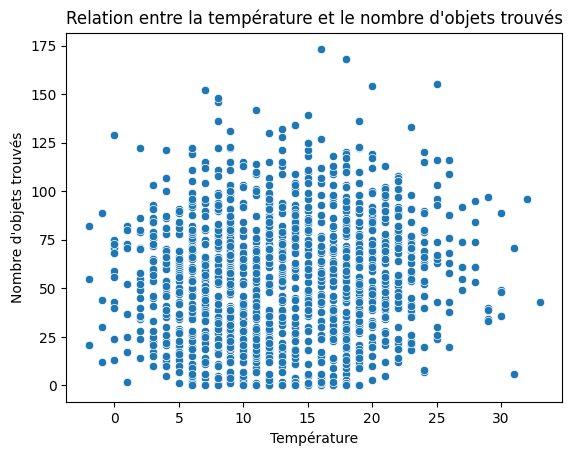

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df,x=1,y=2)
plt.gca().set_title("Relation entre la température et le nombre d'objets trouvés")
plt.xlabel("Température")
plt.ylabel("Nombre d'objets trouvés")

In [78]:
correlation = df[1].corr(df[2])

correlation

0.09499339986109094